In [2]:
import os 
import time
import copy

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import random 
import pandas as pd

using device cuda:0


In [670]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [357]:
def usecuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

In [3]:
path = !pwd
path = path[0]
print(path)

/home/r2/Documents/RNNtest


In [ ]:
data = pd.read_pickle(path+"/data/step3_DAT_MT_USDJPY_M1_2018_merged_pickled") 
data.head()

### functions

In [721]:
def load_trumpdata(datapath):
    import json 
    f = open(datapath,"r")
    data = f.readline()
    f.close()
    data_tr = json.loads(data)
    tweets   = []
    tweet_str = ''
    for line in range(0,len(data_tr)):
        tweet = data_tr[line]["text"].rstrip('\\') + '€'
        tweets.append(tweet)
        tweet_str = tweet_str + tweet
    symbols = list(set(tweet_str))
    decoder = {idx: symbols[idx] for idx in range(0,len(symbols))}
    encoder = {symbols[idx]: idx for idx in range(0,len(symbols))}        
    return tweets, tweet_str, decoder, encoder

def onehencode(symbol, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[symbol]] = 1
    return usecuda(x.t())

def generate_input(e, seq_len, tweet_str):
    Xstr = tweet_str[e:e+seq_len]
    Ystr = tweet_str[e+1:e+seq_len+1]
    X, Y = torch.zeros(seq_len,1,len(encoder)),torch.zeros(seq_len,1)
    for i in range(len(Xstr)):
        x = onehencode(Xstr[i], encoder)
        X[i][:] = x
        Y[i] = encoder[Ystr[i]]
    return usecuda(X),usecuda(Y.long())

def train(X,Y,hidden):
    
    rnn.zero_grad()
    loss = 0
    for i in range(X.size()[0]):
        output, hidden = rnn.forward(X[i],hidden)
        l = criterion(output,Y[i])
        loss += l


    loss.backward()
    
    # update parameters
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)

    return loss / X.size()[0], hidden.detach()

def generate_seq(model, hidden, symbol, seq_len, m, seed):
    with torch.no_grad():
        result_str = symbol
        for i in range(seq_len):
            x = onehencode(symbol,encoder)
            output, new_hidden = model.forward(x,hidden)
        
            hidden = new_hidden.detach()
            prob = np.exp(output.detach().data.cpu().numpy())
            cum_prob = np.cumsum(prob)

            a = random.random()
            idx = np.where(cum_prob - a > 0)[0][0]
            symbol = decoder[idx]
            result_str += symbol

        return result_str
    
def save_checkpoint(state, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='models/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)    
    for item in iter(checkpoint):
        print(item)
    model = RNN(checkpoint['in_sz'],checkpoint['hd_sz'],checkpoint['out_sz'])
    model.load_state_dict(checkpoint['state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss    

## my RNN module

In [709]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])

### code

In [ ]:
tweets, tweet_str, decoder, encoder = load_trumpdata(path+"/data/trump/condensed_2018.json")

In [711]:
start = time.time()

print_every = 500
plot_every = 100

m, lr, hsize, seq_len = len(encoder), 0.005, 150, 30
hidden = usecuda(torch.zeros(1,hsize))

rnn = usecuda(RNN(m,hsize,m))
criterion = nn.NLLLoss()

current_loss = 0 
all_losses = []

# itters = round((len(tweet_str)/(seq_len+1))) - 2
itter  = 1000
epochs = 1
lrs    = [lr*1, lr*0.1, lr*0.01]

for epoch in range(epochs):
    e = 0 
    i = 0

    while i < itters:
        X,Y = generate_input(e,seq_len,tweet_str)  
        loss, hidden = train(X,Y,hidden)

        current_loss += loss 
        e += seq_len + 1
        i += 1
        if i%print_every == 0:
            print(f"""loss is {current_loss/plot_every}""")
            print(generate_seq(hidden,'T',100,m,42))
            print(tweet_str[e:e+seq_len])
        if i%plot_every == 0:
            all_losses.append(current_loss/plot_every)
            current_loss = 0 
            
    print(f"""\n epoch {epoch} took {time.time() - start:.2f} seconds""")       

loss is 3.1228654384613037
Tdte tnul密i€s ke,ps.en ィdro.aa. Ssne 機eof toidte @aipta ee r te noeohenvvpedokyeてentnoreheB kitlo g g
that’s what I told the people 
loss is 2.9637718200683594
Tdrea din さfe souoリiani平lg. sromnSond io€ yeliel!draybgne .osessAhocol.lo.dhe.nneropoulassEnbmli Eotr
n costs the United States more
loss is 2.8464183807373047
Tacn ]eii ae wo @e onr tho irrenan . rSaHleat wsse inLp２Df ouyeplic’fayisTFanro inE ianin. -hare sst 
p; we are having a great time 
loss is 2.749354839324951
Ty 0o — tge sied alac don he the en Wnadsisimved pg rwmhRe nelpeuiem’ thtkrenツ Am innkre hample oh !a
 U.S. Currently the tariff is 
loss is 2.681286573410034
T ck€ffdcoBksthe , tlras  aon  hes Font 4o lanige sct- 開nl  Ded purede Ci sol Drdyy iy ang blanpDhA, 
 soon be coming out called “Th
loss is 2.832164764404297
Tcon in !sty nokl Sivr suca識 oasdst Uer ded atouhuss the pevllilgng tomndltTr ahen tha€eaR ir batie w
y, which is critical to our Na
loss is 2.8263816833496094
Te Ane vor todv’

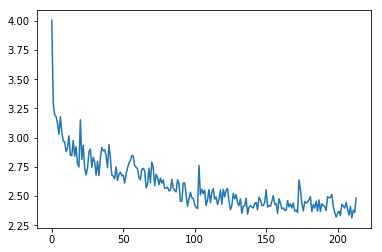

In [713]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
save_checkpoint({
            'epoch': epoch,
            'arch': "1_RNN",
            'state_dict': rnn.state_dict(),
            'hd_sz': rnn.hd_sz,
            'in_sz': rnn.in_sz,
            'out_sz': rnn.out_sz,
            'loss': loss,
            'best_prec1': None,
            'optimizer' : None,
        })

In [724]:
rnn2, epoch, loss = load_checkpoint(filename='models/checkpoint.pth.tar')
rnn2.cuda()

epoch
arch
state_dict
hd_sz
in_sz
out_sz
loss
best_prec1
optimizer


RNN(
  (h1): Linear(in_features=418, out_features=150, bias=True)
  (o1): Linear(in_features=418, out_features=268, bias=True)
  (softmax): LogSoftmax()
)

In [734]:
print(generate_seq(rnn2, torch.zeros(1,hsize).cuda(),'T',100,m,42))
print(generate_seq(rnn, torch.zeros(1,hsize).cuda(),'T',100,m,42))

TDurk ward relust Tsemy Dngrlves. Wtt7 Hus Mhey aru offrreave Ssath” Thepdacn ster ardan four Deforre
Tは, merat Souuas, of io buecrse . at ana revust with wsingRe!yBwsan and Uaust ffoV ReColy o xuthen at


### build RNN network with LSTM

In [475]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_sizes = hidden_size
        self.in_size      = input_size
        self.out_size     = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])


### cut input into seq length bits

In [21]:
data = data[['Open','High','Low','Close']]

In [22]:
cutoff = 0.2
set_train = data[0:round(len(data)*cutoff)]
set_test  = data[round(len(data)*cutoff):-1]

In [43]:
# set_train.head()

In [38]:
input_sz = set_train.shape[1]
hidden_sz = 100
output_sz = 1

In [41]:
rnn = RNN(input_sz, hidden_sz, output_sz)

In [42]:
# for index, row in set_train.iterrows():
#     print(np.array(row))

In [20]:
lr = 0.005

def train(X,Y)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)
        
    loss = criterion(output, )

,Date,Open,High,Low,Close,Volume
0,2000-05-30 17:58:00,106.6000,106.6000,106.6000,106.6000,0
1,2000-05-30 17:59:00,106.625,106.625,106.625,106.625,0
2,2000-05-30 18:00:00,106.625,106.625,106.625,106.625,0
3,2000-05-30 18:01:00,106.625,106.625,106.625,106.625,0
4,2000-05-30 18:02:00,106.625,106.625,106.625,106.625,0
